# CS 20 : TensorFlow for Deep Learning Research
## Lecture 11 : Recurrent Neural Networks
Simple example for Many to One Classification (word sentiment classification) by Recurrent Neural Networks. 

### Many to One Classification by RNN
- Creating the **data pipeline** with `tf.data`
- Preprocessing word sequences (variable input sequence length) using `padding technique` by `tf.keras.preprocessing.sequence.pad_sequences`
- Using `tf.nn.embedding_lookup` for getting vector of tokens (eg. word, character)
- Creating the model as **Class**
- Reference
    - https://github.com/golbin/TensorFlow-Tutorials/blob/master/10%20-%20RNN/02%20-%20Autocomplete.py
    - https://github.com/aisolab/TF_code_examples_for_Deep_learning/blob/master/Tutorial%20of%20implementing%20Sequence%20classification%20with%20RNN%20series.ipynb


### Setup

In [1]:
from __future__ import absolute_import, division, print_function
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
import string
%matplotlib inline

print(tf.__version__)

tf.enable_eager_execution()

1.12.0


### Prepare example data

In [2]:
words = ['good', 'bad', 'amazing', 'so good', 'bull shit', 'awesome']
y = [[1.,0.], [0.,1.], [1.,0.], [1., 0.],[0.,1.], [1.,0.]]

In [3]:
# Character quantization
char_space = string.ascii_lowercase 
char_space = char_space + ' ' + '*'
char_space = list(char_space)
char_space.insert(0, '<pad>')
print(char_space)

['<pad>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '*']


In [4]:
char2idx = {char : idx for idx, char in enumerate(char_space)}
print(char2idx)

{'<pad>': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, ' ': 27, '*': 28}


### padding example data

In [5]:
words = list(map(lambda word : [char2idx.get(char) for char in word],words))

max_length = 10
X_length = list(map(lambda word : len(word), words))
X_indices = pad_sequences(sequences=words, maxlen=max_length, padding='post', truncating='post')

print(X_length)
print(np.shape(X_indices))

[4, 3, 7, 7, 9, 7]
(6, 10)


### Define CharRNN class

In [6]:
class CharRNN(keras.Model):
    def __init__(self, num_classes, hidden_dim, max_length, dic):
        super(CharRNN, self).__init__()

        self.look_up = keras.layers.Embedding(input_dim=len(dic), output_dim=len(dic),
                                         trainable=False, mask_zero=True, input_length=max_length,
                                         embeddings_initializer=keras.initializers.Constant(np.eye(len(dic))))
        self.rnn_cell = keras.layers.SimpleRNN(units=hidden_dim, return_sequences=True,
                                               return_state=True)
        self.dense = keras.layers.Dense(units=num_classes)
        
    def call(self, inputs):
        token_representation = self.look_up(inputs)        
        _, final_h = self.rnn_cell(token_representation)
        score = self.dense(final_h)
        return score

### Create a model of CharRNN

In [7]:
# hyper-parameter#
lr = .003
epochs = 10
batch_size = 2
total_step = int(np.shape(X_indices)[0] / batch_size)
print(total_step)

3


In [8]:
## create data pipeline with tf.data
tr_dataset = tf.data.Dataset.from_tensor_slices((X_indices, y))
tr_dataset = tr_dataset.shuffle(buffer_size = 20)
tr_dataset = tr_dataset.batch(batch_size = batch_size)
print(tr_dataset)

<BatchDataset shapes: ((?, 10), (?, 2)), types: (tf.int32, tf.float32)>


In [9]:
char_rnn = CharRNN(num_classes=2, hidden_dim=16, dic=char2idx, max_length=10)

### Train model

In [10]:
def loss_fn(model, x, y):
    return tf.losses.softmax_cross_entropy(onehot_labels=y, logits=model(x))

In [11]:
opt = tf.train.AdamOptimizer(learning_rate=lr)

In [12]:
tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb in tr_dataset:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(char_rnn, x=x_mb, y=y_mb)
        grads = tape.gradient(target=tr_loss, sources=char_rnn.variables)
        opt.apply_gradients(grads_and_vars=zip(grads, char_rnn.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    else:
        avg_tr_loss /= tr_step
        tr_loss_hist.append(avg_tr_loss)
    
    print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch + 1, avg_tr_loss))

epoch :   1, tr_loss : 0.739
epoch :   2, tr_loss : 0.649
epoch :   3, tr_loss : 0.546
epoch :   4, tr_loss : 0.444
epoch :   5, tr_loss : 0.367
epoch :   6, tr_loss : 0.272
epoch :   7, tr_loss : 0.215
epoch :   8, tr_loss : 0.156
epoch :   9, tr_loss : 0.113
epoch :  10, tr_loss : 0.088


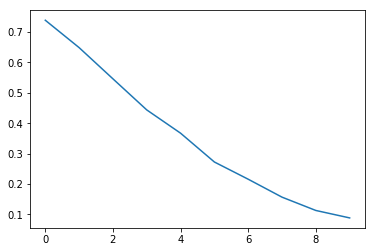

In [13]:
plt.plot(tr_loss_hist, label = 'train')

In [14]:
yhat = np.argmax(char_rnn(inputs=tf.convert_to_tensor(X_indices)), axis=-1)
print('acc : {:.2%}'.format(np.mean(yhat == np.argmax(y, axis=-1))))

acc : 100.00%
